<a href="https://colab.research.google.com/github/shanikairoshi/QML-and-Deep-Unfolded_QML/blob/main/D_VQC_BreastCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install qiskit-machine-learning
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer
from IPython.display import clear_output
clear_output()

<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-12-8c9b8448056a>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  label = 'Malignant' if k is 1 else 'Benign'


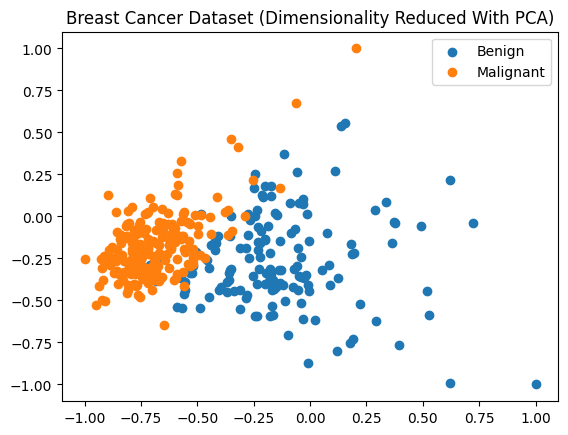

Training data shape: (349, 2)
Testing data shape: (49, 2)


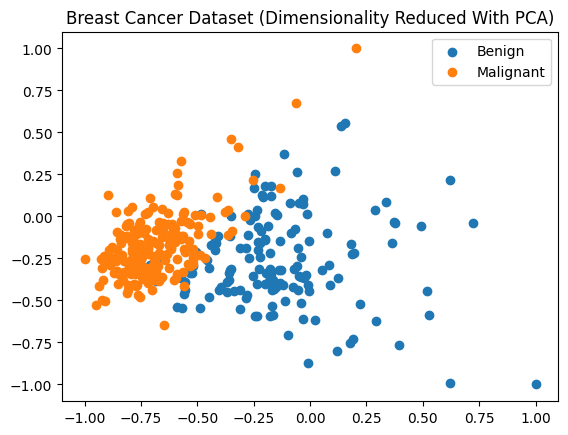

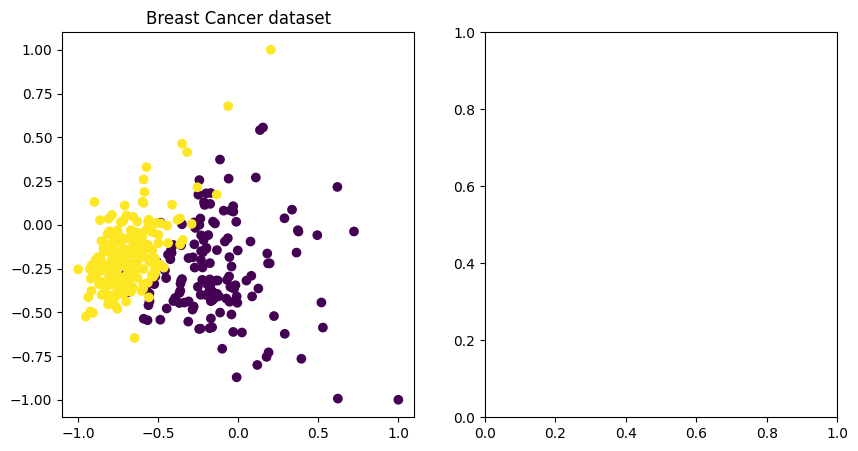

In [12]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


def breast_cancer(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'Benign', r'Malignant']

    # First the dataset must be imported.
    cancer = datasets.load_breast_cancer()

    # To find if the classifier is accurate, a common strategy is
    # to divide the dataset into a training set and a test set.
    # Here the data is divided into 70% training, 30% testing.
    X_train, X_test, Y_train, Y_test = train_test_split(cancer.data, cancer.target, test_size=0.3, random_state=109)

    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    # Now some sample should be picked to train the model from
    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_train[Y_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]

            label = 'Malignant' if k is 1 else 'Benign'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("Breast Cancer Dataset (Dimensionality Reduced With PCA)")
        plt.legend()
        plt.show()


    return X_train, training_input, test_input, class_labels

def split_dataset_to_data_and_labels(input_data):
    data = []
    labels = []
    for label, features in input_data.items():
        data.append(features)
        # Convert labels to 0 and 1
        if label == 'Benign':
            labels.append([0] * len(features))
        else:
            labels.append([1] * len(features))
    return np.vstack(data), np.hstack(labels)

# Set parameters
n = 2  # Number of principal components
training_dataset_size = 200
testing_dataset_size = 100

# Get the dataset and split it
sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

# Split dataset into data and labels
data_train, train_labels = split_dataset_to_data_and_labels(training_input)
data_test, test_labels = split_dataset_to_data_and_labels(test_input)

# Print shapes to verify
print(f"Training data shape: {data_train.shape}")
print(f"Testing data shape: {data_test.shape}")


sample_Total, training_input, test_input, class_labels = breast_cancer(training_dataset_size, testing_dataset_size, n)

data_train, data_train_labels = split_dataset_to_data_and_labels(training_input)
data_test, data_test_labels = split_dataset_to_data_and_labels(test_input)


fig,ax=plt.subplots(1,2,figsize=(10,5))

# Access the data directly from data_train using slicing
ax[0].scatter(data_train[:,0],data_train[:,1],c=data_train_labels) # Use data_train_labels for color coding
ax[0].set_title('Breast Cancer dataset');

<ipython-input-13-270518786f34>:39: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


Training the VQC on breastcancer data...
Training Accuracy: 79.08%
Test Accuracy: 93.88%


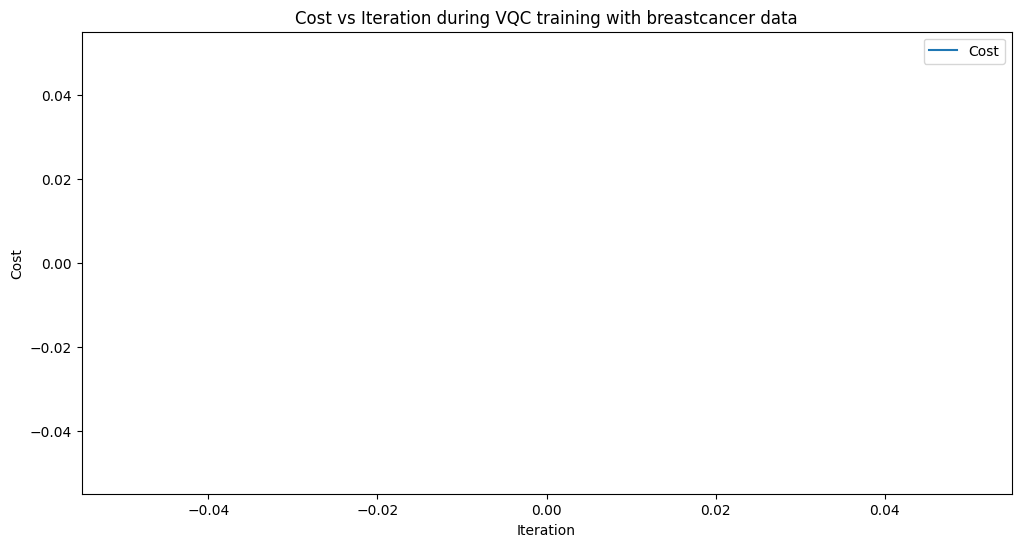

Learning rate data not available for the selected optimizer.


In [13]:
from qiskit_machine_learning.datasets import ad_hoc_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import csv
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.utils.loss_functions import Loss
from qiskit_algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit_algorithms.utils import algorithm_globals # Import algorithm_globals
from sklearn.datasets import load_iris
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

# Set random seed for reproducibility using algorithm_globals
algorithm_globals.random_seed = 42  # Set seed globally



# Step 2: Define feature map and ansatz

# Define quantum feature map and ansatz
feature_dim = data_train.shape[1]
prep = ZZFeatureMap(feature_dim, reps=2)
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=4)

#FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
#ANSATZ = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

# Step 3: Define optimizer (SPSA for example)
OPTIMIZER = SPSA(maxiter=60, learning_rate=0.1, perturbation=0.1)

# Step 4: Initialize VQC
sampler = Sampler()
vqc = VQC(
    sampler=sampler,
    feature_map=prep,
    ansatz=ansatz,
    optimizer=OPTIMIZER,
    loss="cross_entropy",  # Using cross-entropy loss
)

# Step 5: Train the VQC model
print("Training the VQC on breastcancer data...")
vqc.fit(data_train, data_train_labels)

# Step 6: Test the model
test_predictions = vqc.predict(data_test)
train_predictions = vqc.predict(data_train)

# Step 7: Evaluate the accuracy
test_accuracy = accuracy_score(data_test_labels, test_predictions)
train_accuracy = accuracy_score(data_train_labels, train_predictions)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Optional: Plot the results (training cost over iterations)
# Initialize CSV file to log training data (costs)
csv_file = "breastcancer_vqc_training_log.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Cost", "LearningRate"])

objective_func_vals = []
learning_rates = []

def callback_graph(weights, obj_func_eval):
    # Clear the previous plot
    clear_output(wait=True)

    objective_func_vals.append(obj_func_eval)

    if isinstance(OPTIMIZER, SPSA):
        learning_rates.append(OPTIMIZER.learning_rate)
    else:
        learning_rates.append(None)

    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([len(objective_func_vals), obj_func_eval, learning_rates[-1]])

    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Plot the cost over iterations if the training was logged
data = pd.read_csv(csv_file)

plt.figure(figsize=(12, 6))
plt.plot(data["Iteration"], data["Cost"], label="Cost")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost vs Iteration during VQC training with breastcancer data")
plt.legend()
plt.show()

# Plot the learning rate if available
if not data["LearningRate"].isnull().all():
    plt.figure(figsize=(12, 6))
    plt.plot(data["Iteration"], data["LearningRate"], label="Learning Rate", color='orange')
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate vs Iteration during VQC training with breastcancer data")
    plt.legend()
    plt.show()
else:
    print("Learning rate data not available for the selected optimizer.")


The follwing code implementation is refer the default qiskit vqc model and it shows environment setting as follows:
1.

# **The following implementation shows how deep unfolding implement in vqc qiskit algorithm**



Let's try to evaluate different featuremaps, datasets, and optimizers in following code for default qiskit.

<ipython-input-5-c68399f17b76>:89: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)


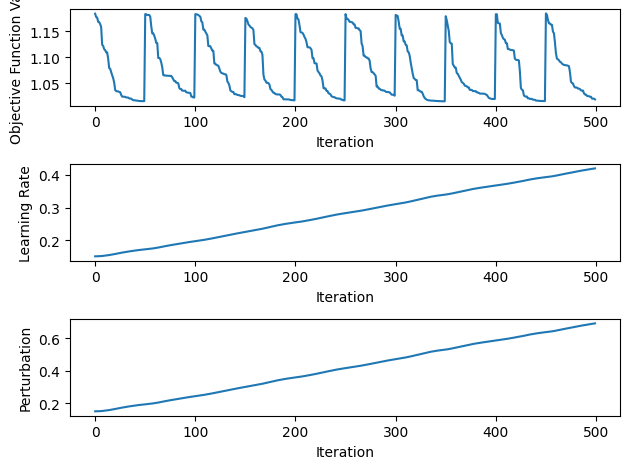

Iteration 10 - Training Accuracy: 50.00%
Iteration 10 - Test Accuracy: 54.00%
Final Training Accuracy: 50.00%
Final Test Accuracy: 54.00%
Total Training Time: 787.35 seconds


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms.classifiers import VQC

from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import SPSA
import time
from IPython.display import clear_output
import csv

from qiskit_algorithms.utils import algorithm_globals

# Set random seed for reproducibility
algorithm_globals.random_seed = 42

from sklearn.datasets import load_iris
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

# Set random seed for reproducibility using algorithm_globals
algorithm_globals.random_seed = 42  # Set seed globally


# Step 2: Define feature map and ansatz

# Define quantum feature map and ansatz
feature_dim = data_train.shape[1]
prep = ZZFeatureMap(feature_dim, reps=2)
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=4)

# Variables to track objective function, learning rate, and perturbation
objective_func_vals = []
learning_rates = []
perturbations = []
initial_learning_rate = 0.15  # Starting learning rate
initial_perturbation = 0.15  # Starting perturbation value
momentum = 0.95  # Momentum factor for gradient smoothing
gradient_moving_avg_lr = 0
gradient_moving_avg_pert = 0



# Callback for visualization and adjustment, matching the number of arguments expected
def deep_unfolding_learning_rate_adjustment(nfev, parameters, obj_func_eval, stepsize=None, accept=None):
    global gradient_moving_avg_lr, gradient_moving_avg_pert, learning_rates, perturbations

    clear_output(wait=True)

    # Save the objective function value for visualization
    objective_func_vals.append(obj_func_eval)

    # Apply momentum and update learning rate if gradient is available
    if stepsize is not None:
        gradient_moving_avg_lr = momentum * gradient_moving_avg_lr + (1 - momentum) * stepsize
        delta_lr = 0.01 * gradient_moving_avg_lr
    else:
        delta_lr = 0

    # Apply momentum and update perturbation if gradient is available
    if stepsize is not None:
        gradient_moving_avg_pert = momentum * gradient_moving_avg_pert + (1 - momentum) * stepsize
        delta_perturbation = 0.02 * gradient_moving_avg_pert
    else:
        delta_perturbation = 0

    # Cap learning rate and perturbation updates to avoid runaway values
    max_lr = 1.0  # Maximum allowed learning rate
    max_perturbation = 1.0  # Maximum allowed perturbation

    # Update learning rate and perturbation with caps
    if len(learning_rates) > 0:
        new_lr = max(0.001, min(max_lr, learning_rates[-1] + delta_lr))
        new_perturbation = max(0.001, min(max_perturbation, perturbations[-1] + delta_perturbation))
    else:
        new_lr = initial_learning_rate
        new_perturbation = initial_perturbation

    learning_rates.append(new_lr)
    perturbations.append(new_perturbation)

    # Visualization of learning rate, perturbation, and objective function
    plt.title("Objective Function, Learning Rate, and Perturbation")

    plt.subplot(3, 1, 1)
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)

    plt.subplot(3, 1, 2)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.plot(range(len(learning_rates)), learning_rates)

    plt.subplot(3, 1, 3)
    plt.xlabel("Iteration")
    plt.ylabel("Perturbation")
    plt.plot(range(len(perturbations)), perturbations)

    plt.tight_layout()
    plt.show()

# Custom SPSA optimizer with learnable learning rate and perturbation
class LearnableLRPerturbationSPSA(SPSA):
    def __init__(self, initial_lr=0.01, initial_perturbation=0.1, lr_alpha=0.01, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = initial_lr
        self.perturbation = initial_perturbation
        self.lr_alpha = lr_alpha

    def _compute_lr_gradient(self, fun, point, grad):
        epsilon_lr = 1e-4  # Small value for finite difference approximation
        lr_plus = self.lr + epsilon_lr
        lr_minus = self.lr - epsilon_lr

        point_plus = point - lr_plus * grad
        point_minus = point - lr_minus * grad

        grad_lr = (fun(point_plus) - fun(point_minus)) / (2 * epsilon_lr)
        return grad_lr

    def _compute_perturbation_gradient(self, fun, point, grad):
        epsilon_pert = 1e-4
        pert_plus = self.perturbation + epsilon_pert
        pert_minus = self.perturbation - epsilon_pert

        point_plus = point - pert_plus * grad
        point_minus = point - pert_minus * grad

        grad_pert = (fun(point_plus) - fun(point_minus)) / (2 * epsilon_pert)
        return grad_pert

    def _update_learning_rate_and_perturbation(self, parameters, obj_func_eval, iteration):
        lr_gradient = self._compute_lr_gradient(self.objective_function, parameters, obj_func_eval)
        pert_gradient = self._compute_perturbation_gradient(self.objective_function, parameters, obj_func_eval)

        # Cap the gradient updates to avoid large changes
        max_grad = 10
        lr_gradient = np.clip(lr_gradient, -max_grad, max_grad)
        pert_gradient = np.clip(pert_gradient, -max_grad, max_grad)

        # Apply meta-learning rate updates
        self.lr += self.lr_alpha * lr_gradient
        self.perturbation += self.lr_alpha * pert_gradient

        # Apply decay and cap to ensure values remain within reasonable range
        decay = 0.99
        self.lr = max(0.001, min(1.0, self.lr * decay))
        self.perturbation = max(0.001, min(1.0, self.perturbation * decay))

    def step(self, gradient, obj_func_eval):
        self._update_learning_rate_and_perturbation(gradient, obj_func_eval)
        return super().step(gradient)

# Create optimizer with learnable learning rate and perturbation
spsa_optimizer = LearnableLRPerturbationSPSA(
    maxiter=50, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=deep_unfolding_learning_rate_adjustment, lr_alpha=0.01
)

# Initialize VQC model with the deep unfolding optimizer
sampler = Sampler()
vqc = VQC(
    feature_map=prep,
    ansatz=ansatz,
    optimizer=spsa_optimizer,
    sampler=sampler,
)
'''
# Step 4: Initialize VQC
sampler = Sampler()
vqc = VQC(
    sampler=sampler,
    feature_map=prep,
    ansatz=ansatz,
    optimizer=OPTIMIZER,
    loss="cross_entropy",  # Using cross-entropy loss
)
'''

# Prepare to save results in a CSV file
csv_file = "dvqc_training_results.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Objective Function Value", "Training Accuracy", "Test Accuracy", "Learning Rate", "Perturbation"])

train_accuracies = []
test_accuracies = []

# Deep Unfolding with multiple iterations
total_time = 0

for i in range(10):
    print(f"Deep Unfolding Iteration {i+1}/10")

    start_time = time.time()
    vqc.fit(data_train, data_train_labels)
    end_time = time.time()
    total_time += end_time - start_time

    final_learning_rate = learning_rates[-1]
    final_perturbation = perturbations[-1]

    train_accuracy = vqc.score(data_train, data_train_labels)
    test_accuracy = vqc.score(data_test, data_test_labels)

    print(f"Iteration {i+1} - Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy * 100:.2f}%")

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([i+1, objective_func_vals[-1], train_accuracy * 100, test_accuracy * 100, final_learning_rate, final_perturbation])

print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Total Training Time: {total_time:.2f} seconds")


<ipython-input-15-934231d35b71>:81: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)


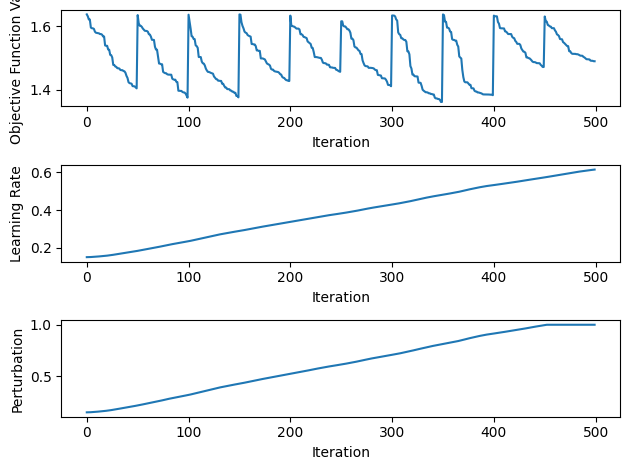

Iteration 10 - Training Accuracy: 41.33%
Iteration 10 - Test Accuracy: 42.67%
Final Training Accuracy: 41.33%
Final Test Accuracy: 42.67%
Total Training Time: 1997.71 seconds


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import SPSA
import time
from IPython.display import clear_output
import csv
from qiskit_algorithms.utils import algorithm_globals
from sklearn.datasets import load_iris

# Set random seed for reproducibility
algorithm_globals.random_seed = 42

# Load dataset (Iris dataset for this example)
iris = load_iris()
data_train = iris.data
data_train_labels = iris.target

# Split dataset into train and test (in this case just a simple split)
data_test = data_train[::2]
data_test_labels = data_train_labels[::2]

# Step 2: Define feature map and ansatz
feature_dim = data_train.shape[1]
prep = ZZFeatureMap(feature_dim, reps=2)
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=4)

# Variables to track objective function, learning rate, and perturbation
objective_func_vals = []
learning_rates = []
perturbations = []
initial_learning_rate = 0.15  # Starting learning rate
initial_perturbation = 0.15  # Starting perturbation value
momentum = 0.95  # Momentum factor for gradient smoothing
gradient_moving_avg_lr = 0
gradient_moving_avg_pert = 0

# Callback for visualization and adjustment
def deep_unfolding_learning_rate_adjustment(nfev, parameters, obj_func_eval, stepsize=None, accept=None):
    global gradient_moving_avg_lr, gradient_moving_avg_pert, learning_rates, perturbations

    clear_output(wait=True)

    # Save the objective function value for visualization
    objective_func_vals.append(obj_func_eval)

    # Apply momentum and update learning rate if gradient is available
    if stepsize is not None:
        gradient_moving_avg_lr = momentum * gradient_moving_avg_lr + (1 - momentum) * stepsize
        delta_lr = 0.01 * gradient_moving_avg_lr
    else:
        delta_lr = 0

    # Apply momentum and update perturbation if gradient is available
    if stepsize is not None:
        gradient_moving_avg_pert = momentum * gradient_moving_avg_pert + (1 - momentum) * stepsize
        delta_perturbation = 0.02 * gradient_moving_avg_pert
    else:
        delta_perturbation = 0

    # Cap learning rate and perturbation updates to avoid runaway values
    max_lr = 1.0  # Maximum allowed learning rate
    max_perturbation = 1.0  # Maximum allowed perturbation

    # Update learning rate and perturbation with caps
    if len(learning_rates) > 0:
        new_lr = max(0.001, min(max_lr, learning_rates[-1] + delta_lr))
        new_perturbation = max(0.001, min(max_perturbation, perturbations[-1] + delta_perturbation))
    else:
        new_lr = initial_learning_rate
        new_perturbation = initial_perturbation

    learning_rates.append(new_lr)
    perturbations.append(new_perturbation)

    # Visualization of learning rate, perturbation, and objective function
    plt.title("Objective Function, Learning Rate, and Perturbation")

    plt.subplot(3, 1, 1)
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)

    plt.subplot(3, 1, 2)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.plot(range(len(learning_rates)), learning_rates)

    plt.subplot(3, 1, 3)
    plt.xlabel("Iteration")
    plt.ylabel("Perturbation")
    plt.plot(range(len(perturbations)), perturbations)

    plt.tight_layout()
    plt.show()

# Custom SPSA optimizer with learnable learning rate and perturbation
class LearnableLRPerturbationSPSA(SPSA):
    def __init__(self, initial_lr=0.01, initial_perturbation=0.1, lr_alpha=0.005, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lr = initial_lr
        self.perturbation = initial_perturbation
        self.lr_alpha = lr_alpha
        self.previous_obj_func_eval = None  # Track the previous objective function evaluation

    def _compute_lr_gradient(self, fun, point, grad):
        epsilon_lr = 1e-5  # Smaller value for finite difference approximation
        lr_plus = self.lr + epsilon_lr
        lr_minus = self.lr - epsilon_lr

        point_plus = point - lr_plus * grad
        point_minus = point - lr_minus * grad

        grad_lr = (fun(point_plus) - fun(point_minus)) / (2 * epsilon_lr)
        return grad_lr

    def _compute_perturbation_gradient(self, fun, point, grad):
        epsilon_pert = 1e-5  # Smaller perturbation step to reduce noise
        pert_plus = self.perturbation + epsilon_pert
        pert_minus = self.perturbation - epsilon_pert

        point_plus = point - pert_plus * grad
        point_minus = point - pert_minus * grad

        grad_pert = (fun(point_plus) - fun(point_minus)) / (2 * epsilon_pert)
        return grad_pert

    def _update_learning_rate_and_perturbation(self, parameters, obj_func_eval, iteration):
        lr_gradient = self._compute_lr_gradient(self.objective_function, parameters, obj_func_eval)
        pert_gradient = self._compute_perturbation_gradient(self.objective_function, parameters, obj_func_eval)

        # Cap the gradient updates to avoid large changes
        max_grad = 5  # Smaller cap for stability
        lr_gradient = np.clip(lr_gradient, -max_grad, max_grad)
        pert_gradient = np.clip(pert_gradient, -max_grad, max_grad)

        # Apply meta-learning rate updates
        self.lr += self.lr_alpha * lr_gradient
        self.perturbation += self.lr_alpha * pert_gradient

        # Apply decay and cap to ensure values remain within reasonable range
        decay = 0.99
        self.lr = max(0.001, min(0.5, self.lr * decay))  # Reduced upper bound
        self.perturbation = max(0.001, min(0.5, self.perturbation * decay))  # Reduced upper bound

        # Adaptive behavior: if the cost increases, decrease learning rate
        if self.previous_obj_func_eval is not None and obj_func_eval > self.previous_obj_func_eval:
            self.lr *= 0.9  # Reduce learning rate if cost increases
        self.previous_obj_func_eval = obj_func_eval

    def step(self, gradient, obj_func_eval):
        self._update_learning_rate_and_perturbation(gradient, obj_func_eval)
        return super().step(gradient)

# Updated optimizer with smaller adjustment rates and stability enhancements
spsa_optimizer = LearnableLRPerturbationSPSA(
    maxiter=50, learning_rate=initial_learning_rate, perturbation=initial_perturbation, callback=deep_unfolding_learning_rate_adjustment, lr_alpha=0.005
)

# Initialize VQC model with the deep unfolding optimizer
sampler = Sampler()
vqc = VQC(
    feature_map=prep,
    ansatz=ansatz,
    optimizer=spsa_optimizer,
    sampler=sampler,
)

# Prepare to save results in a CSV file
csv_file = "dvqc_training_results.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Iteration", "Objective Function Value", "Training Accuracy", "Test Accuracy", "Learning Rate", "Perturbation"])

train_accuracies = []
test_accuracies = []

# Deep Unfolding with multiple iterations
total_time = 0

for i in range(10):
    print(f"Deep Unfolding Iteration {i+1}/10")

    start_time = time.time()
    vqc.fit(data_train, data_train_labels)
    end_time = time.time()
    total_time += end_time - start_time

    final_learning_rate = learning_rates[-1]
    final_perturbation = perturbations[-1]

    train_accuracy = vqc.score(data_train, data_train_labels)
    test_accuracy = vqc.score(data_test, data_test_labels)

    print(f"Iteration {i+1} - Training Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy * 100:.2f}%")

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([i+1, objective_func_vals[-1], train_accuracy * 100, test_accuracy * 100, final_learning_rate, final_perturbation])

print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Total Training Time: {total_time:.2f} seconds")

'''
Key Changes:
Smaller lr_alpha: The step size for learning rate and perturbation updates has been reduced to 0.005 to make the updates more gradual and avoid overshooting.
Smaller Finite Difference (epsilon_lr, epsilon_pert): The finite difference values used to calculate the gradient for learning rate and perturbation have been reduced to 1e-5 for more stable gradient estimation.
Gradient Clipping: The gradients for learning rate and perturbation are more tightly capped (max_grad = 5) to prevent excessive jumps in updates.
Adaptive Learning Rate: The learning rate is decreased (* 0.9) if the cost increases compared to the previous iteration.
Upper Bound on Learning Rate and Perturbation: The upper bounds for learning rate and perturbation have been reduced to 0.5 to prevent them from becoming too large.

'''